In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import re
import oommfpy as op
import oommfpy.tools as ot

In [2]:
omfs = glob.glob('sims/oommf/conical_FeGe_Lx1000nm_Ly100nm_Lz1000nm/conical/*.omf')
omfs = sorted(omfs, key=lambda f: int(re.search(r'(?<=m_Bx)\d\d\d', f).group(0)))

In [3]:
omfs

['sims/oommf/conical_FeGe_Lx1000nm_Ly100nm_Lz1000nm/conical/m_Bx100mT-Oxs_MinDriver-Magnetization-00-0016514.omf',
 'sims/oommf/conical_FeGe_Lx1000nm_Ly100nm_Lz1000nm/conical/m_Bx150mT-Oxs_MinDriver-Magnetization-00-0080177.omf',
 'sims/oommf/conical_FeGe_Lx1000nm_Ly100nm_Lz1000nm/conical/m_Bx200mT-Oxs_MinDriver-Magnetization-00-0034116.omf',
 'sims/oommf/conical_FeGe_Lx1000nm_Ly100nm_Lz1000nm/conical/m_Bx250mT-Oxs_MinDriver-Magnetization-00-0012362.omf']

In [5]:
z_maps = []
hsl_maps = []

for i, omf in enumerate(omfs): 

    data = op.MagnetisationData(omfs[i])
    data.generate_coordinates()
    data.generate_field()
    
    fltr = data.z == data.zs[len(data.zs) // 2]
    z_map = data.field_z[fltr].reshape(len(data.xs), -1)
    
    # HLS colours:
    hsl_map = data.field[fltr]
    hsl_map = ot.generate_colours(hsl_map)
    hsl_map = hsl_map.reshape(len(data.xs), -1, 3)
    
    z_maps.append(np.copy(z_map))
    hsl_maps.append(np.copy(hsl_map))

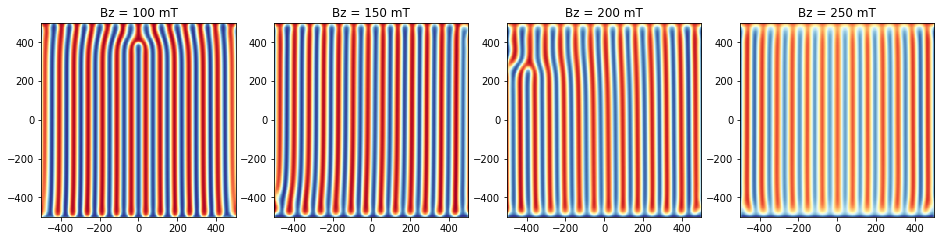

In [6]:
f, axs = plt.subplots(nrows=1, ncols=4, figsize=(16, 24))

for idx, i in enumerate([100, 150, 200, 250]):
    ax = axs.flatten()[idx]
    ax.imshow(z_maps[idx], origin='lower', vmin=-1, vmax=1, cmap='RdYlBu', 
              extent=[data.xs.min() - data.dx * 0.5 * 1e9, data.xs.max() + data.dx * 0.5 * 1e9,
                      data.ys.min() - data.dy * 0.5 * 1e9, data.ys.max() + data.dy * 0.5 * 1e9])
    ax.set_title('Bz = {} mT'.format(i))

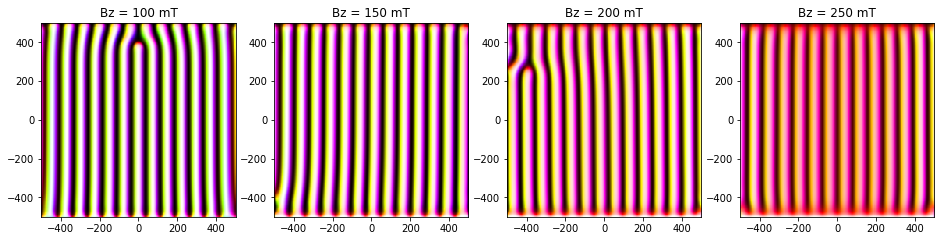

In [7]:
f, axs = plt.subplots(nrows=1, ncols=4, figsize=(16, 24))

for idx, i in enumerate([100, 150, 200, 250]):
    ax = axs.flatten()[idx]
    ax.imshow(hsl_maps[idx], origin='lower', vmin=-1, vmax=1, cmap='RdYlBu',
              extent=[data.xs.min() - data.dx * 0.5 * 1e9, data.xs.max() + data.dx * 0.5 * 1e9,
                      data.ys.min() - data.dy * 0.5 * 1e9, data.ys.max() + data.dy * 0.5 * 1e9])
    ax.set_title('Bz = {} mT'.format(i))

In [19]:
bw_maps = {}

for i, omf in enumerate(omfs): 
    
    bx = int(re.search(r'(?<=m_Bx)\d\d\d', omf).group(0))
    
    data = op.MagnetisationData(omfs[i])
    data.generate_coordinates()
    data.generate_field()
    
    av_map = np.zeros((len(data.xs), len(data.ys)))
    for j, z in enumerate(data.zs):
        fltr = data.z == data.zs[j]
        av_map += data.field_z[fltr].reshape(len(data.xs), -1)
    av_map /= len(data.zs)
        
    bw_maps[bx] = np.copy(av_map)

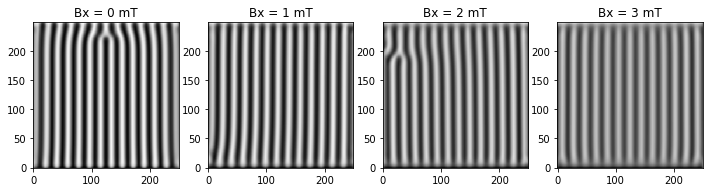

In [20]:
f, axs = plt.subplots(nrows=1, ncols=4, figsize=(12, 12))

for i, bx in enumerate(bw_maps.keys()):
    ax = axs.flatten()[i]
    ax.imshow(bw_maps[bx], origin='lower', vmin=-1, vmax=1, cmap='binary')
    ax.set_title('Bx = {} mT'.format(i))

In [11]:
import os

In [13]:
if not os.path.exists('data_mz_conical'):
    os.makedirs('data_mz_conical')

for idx, i in enumerate(range(4)):
   
    np.savetxt('data_mz_conical/m_Bx_{:03d}_mT.txt'.format(100 + 50 * i), bw_maps[i])

# Wavelength

Attempt at finding the wavelength

In [25]:
import scipy.optimize as so
import scipy.interpolate as si

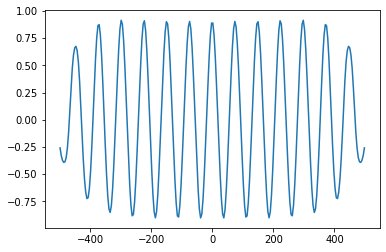

In [30]:
plt.plot(data.xs, bw_maps[100][30])

In [59]:
def func(x, a, b, c):
    return np.sin(a * x + c) + b

In [61]:
popt, pcov = so.curve_fit(func, data.xs[30:-30], bw_maps[100][30][30:-30], p0=[1, 0, 0])

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

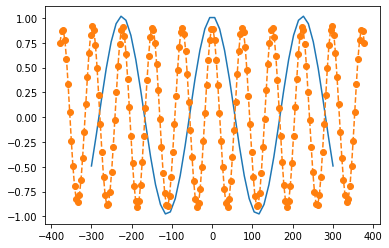

In [56]:
xf = np.linspace(-300, 300)

plt.plot(xf, func(xf, *popt))
plt.plot(data.xs[30:-30], bw_maps[100][30][30:-30], 'o--')